<a href="https://www.kaggle.com/code/khaledabdelgaber/my-roberta-for-bullying-classification?scriptVersionId=179726449" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv


## Custom functions definition:

In [3]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(12,12))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16) 
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [4]:
pip install langdetect

     |████████████████████████████████| 981 kB 6.5 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=c523a8c5678dc14aa96149e67dc072b843a10690cb411c7836d428e485a8b109
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install contractions

     |████████████████████████████████| 101 kB 4.4 MB/s            
     |████████████████████████████████| 289 kB 41.4 MB/s            
Note: you may need to restart the kernel to use updated packages.


## Import libraries

In [6]:
# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text cleaning
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize



# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

# Transformers library for BERT
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix
from transformers import RobertaModel, RobertaTokenizer

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

<Figure size 432x288 with 0 Axes>

## Data Import

In [7]:
df = pd.read_csv("/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv")

In [8]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


First we rename the columns using shorter words for easier reference.

In [10]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

### Are there duplicated tweets?

In [11]:
df.duplicated().sum()

36

There are some duplicated tweets, we will remove them.

In [12]:
df = df[~df.duplicated()]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       47656 non-null  object
 1   sentiment  47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


### Are the classes balanced?

In [14]:
df.sentiment.value_counts()

religion               7997
age                    7992
ethnicity              7959
gender                 7948
not_cyberbullying      7937
other_cyberbullying    7823
Name: sentiment, dtype: int64

The classes look balanced.

# Tweets text deep cleaning

Next, we will define custom functions to clean the texts of the tweets.

In [15]:
contractions.fix("can't")

'cannot'

In [16]:
text = 'I loved my familys'
words = word_tokenize(text)
lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

In [17]:
lemmatized_words

['I', 'loved', 'my', 'family']

In [18]:
# Clean emojis from text
def strip_emoji(text):
    return emoji.get_emoji_regexp().sub("", text)

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()
    
    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()
    
    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [19]:
df['text_clean'] = df['text'].apply(strip_emoji)
df['text_clean'] = df['text_clean'].apply(strip_all_entities)
df['text_clean'] = df['text_clean'].apply(clean_hashtags)
df['text_clean'] = df['text_clean'].apply(remove_mult_spaces)
df['text_clean'] = df['text_clean'].apply(remove_short_words)
df['text_clean'] = df['text_clean'].apply(remove_short_tweets)

In [20]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,words katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcakes
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks heads concerned another angry dude ...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isis account pretending kurdish account like i...


### Are there duplicate tweets after the cleaning?

In [21]:
print(f'There are around {int(df["text_clean"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 4354 duplicated tweets, we will remove them.


In [22]:
df.drop_duplicates("text_clean", inplace=True)

We removed the duplicated cleaned tweets. How is the class balance after the cleaning?

In [23]:
df.sentiment.value_counts()

religion               7947
age                    7881
ethnicity              7768
gender                 7468
not_cyberbullying      6993
other_cyberbullying    5245
Name: sentiment, dtype: int64

Then we also define a list of the classes names, which will be useful for the future plots.

In [24]:
sentiments = ["religion","age","ethnicity","gender","other_cyberbullying","not bullying"]

# Tweets length analysis

Now we will define a new dataframe column containing the length of the cleaned tweets in terms of number of words.

In [25]:
df['text_len'] = [len(text.split()) for text in df.text_clean]

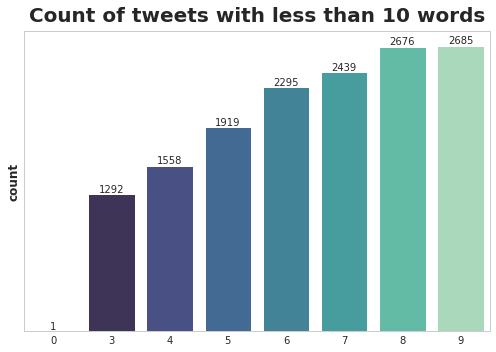

In [26]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

### What about long tweets?

In [27]:
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
29205,is feminazi an actual word with a denot…\r\n@N...,other_cyberbullying,feminazi actual word denot job means protectin...,398
24516,@NICKIMINAJ: #WutKinda\r\nAt this rate the MKR...,other_cyberbullying,wutkinda rate mkr final december mkr haha true...,364
30752,I don't retreat.\r\nyessssssss http://t.co/Td9...,other_cyberbullying,dont retreat yessssssss uh make grownups borut...,250
44035,You so black and white trying to live like a n...,ethnicity,black white trying live like nigger pahahahaha...,183
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,fuck obama dumb ass nigger bitch ltthis whore ...,159
...,...,...,...,...
5028,no school for me tomorrow doe ..,not_cyberbullying,school tomorrow doe,3
30198,@xMarkHenry @xzackryder @xnattiebynature -_-he...,other_cyberbullying,bully ugh god,3
30213,OH MY GOD HELP,other_cyberbullying,oh god help,3
36618,Who did they bully? School us.,age,bully school us,3


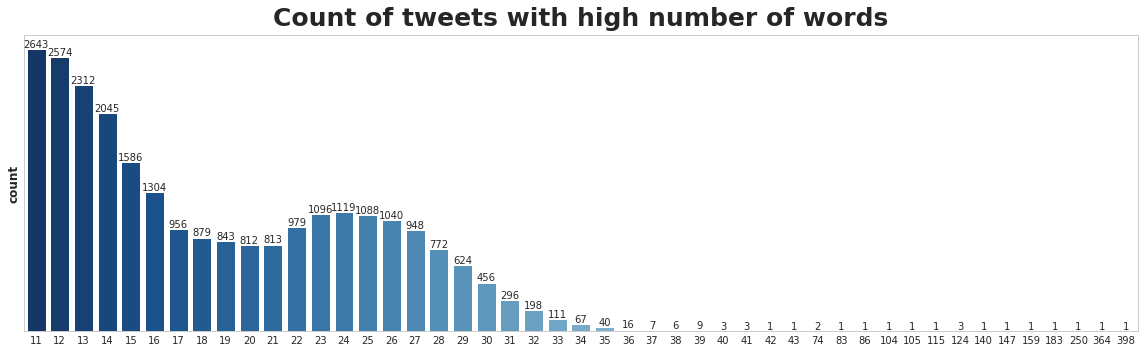

In [28]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

We also will remove tweets that are too long (with more than 100 words).

In [29]:
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

Then we also get the length of the longest tweet since it will be useful later.

In [30]:
max_len = np.max(df['text_len'])
max_len 

32

In [31]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
23406,If you support #IStandWithIlhan you also suppo...,religion,support istandwithilhan also support al qaeda ...,32
20773,Nope. I don’t. And the law is in my side. It’s...,religion,nope dont law side settled see roe vs wade goo...,32
33439,dude it’s crazy the amount of ppl that bullied...,age,dude crazy amount ppl bullied high school came...,32
10755,"Right!? Policing mtg, I called em out cuz I us...",gender,right policing mtg called em cuz used work tra...,32
22629,No need to fake it like The Sociopath Socialis...,religion,need fake like sociopath socialist margaret sa...,32
...,...,...,...,...
1794,"@dannywood I miss your ""BAM standard!"" ;)",not_cyberbullying,miss bam standard,3
21901,@98Halima @johnnygjokaj @cdnKhadija @rfrankh53...,religion,proof mohammed pedophile,3
1796,@GirlyGamerzBRO @megahalfie @NICKIMINAJ u keep...,not_cyberbullying,keep saying ur,3
2060,@ImPaboLikeYou oops yup RM155,not_cyberbullying,oops yup rm155,3


## Sentiment column encoding

The target column will be encoded by ordinal encoding

In [32]:
df['sentiment'] = df['sentiment'].replace({
    'religion':0,
    'age':1,
    'ethnicity':2,
    'gender':3,
    'not_cyberbullying':4,
    'other_cyberbullying':5
})

# ROBERTA Classification

## Train - Validation - Test split

In [33]:
X = df['text_clean'].values
y = df['sentiment'].values

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [35]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

As seen before, we oversample the text to the majority class.

In [36]:
(unique, counts) = np.unique(y_train, return_counts=True)#(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5035],
       [   1, 5012],
       [   2, 4919],
       [   3, 4740],
       [   4, 4473],
       [   5, 3353]])

# RoBERTa Tokenization

Since we need to tokenize the tweets (get "input ids" and "attention masks") for BERT, we load the specific BERT tokenizer from the Hugging Face library.

In [37]:
rob_tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Then we define a custom tokenizer function using the loaded tokenizer.

In [38]:
def roberta_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = rob_tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length 
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [39]:
# Tokenize train tweets
robert_encoded_tweets = [rob_tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in robert_encoded_tweets])
print('Max length: ', max_len)

Max length:  83


We can choose the max length as 128.

In [40]:
MAX_LEN = 128

Then we can tokenize the train, validation and test tweets using the custom define tokenizer.

In [41]:
train_inputs, train_masks = roberta_tokenizer(X_train)#(X_train_os)
val_inputs, val_masks = roberta_tokenizer(X_valid)
test_inputs, test_masks = roberta_tokenizer(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [42]:
train_inputs[1]

tensor([    0,   417,  2533,   269,   575, 11721, 10839,    29,  1524,   575,
           16,  5112, 11620,  1900, 13453, 26032,     2,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1])

In [43]:
train_masks[1]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

## Data preprocessing for PyTorch BERT model

Since we are using the BERT model built on PyTorch, we need to convert the arrays to pytorch tensors and create dataloaders for the data.

In [44]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train)#(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

In [45]:
train_labels

tensor([0, 0, 0,  ..., 2, 1, 2])

## Dataloaders

To fine-tune the BERT model, the original authors recommend a batch size of 16 or 32.

In [46]:
batch_size = 32

In [47]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# ROBERTA Modeling

In [48]:
class Roberta_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Roberta_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 6

        # Instantiate BERT model
        self.roberta = RobertaModel.from_pretrained("roberta-base")

        # Instantiate the classifier (a fully connected layer followed by a ReLU activation and another fully connected layer)
        self.classifier = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.Dropout(0.2),
            nn.LeakyReLU(),
            nn.Linear(n_hidden, n_output)
        )

        # Freeze the BERT model weights if freeze_bert is True (useful for feature extraction without fine-tuning)
        if freeze_bert:
            for param in self.roberta.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input data (input_ids and attention_mask) to BERT
        outputs = self.roberta(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the `[CLS]` token from the BERT output (useful for classification tasks)
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed the extracted hidden state to the classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Moreover, since we want to define a learning rate scheduler, we define a custom "initalize_model" function as follows.

In [49]:
# Function for initializing the BERT Classifier model, optimizer, and learning rate scheduler
def initialize_roberta_model(epochs=4):
    # Instantiate Bert Classifier
    roberta_classifier = Roberta_Classifier(freeze_bert=False)

    roberta_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(roberta_classifier.parameters(),
                      lr=2e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Define the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return roberta_classifier, optimizer, scheduler

We also specify the use of GPU if present (highly recommended for the fine tuning)

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=4

And then we intialize the BERT model calling the "initialize_model" function we defined.

In [51]:
roberta_classifier, roberta_optimizer, roberta_scheduler = initialize_roberta_model(epochs=EPOCHS)

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# ROBERTA Training

After defining the custom BERT classifier model, we are ready to start the training.

In [52]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def train(model, train_dataloader,optimizer,scheduler ,val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0
        
        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch
                
                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###
        
        # Put the model into the evaluation mode
        model.eval()
        
        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)
            
            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy 
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)
        
        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")
    
    print("Training complete!")

### Roberta Training

In [53]:
train(roberta_classifier, train_dataloader,roberta_optimizer, roberta_scheduler, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   1.044945   |   39.29  
   200    |   0.572718   |   37.95  
   300    |   0.508187   |   37.97  
   400    |   0.461539   |   37.95  
   500    |   0.453735   |   37.98  
   600    |   0.391887   |   37.95  
   700    |   0.441903   |   37.93  
   800    |   0.408322   |   37.92  
   860    |   0.405837   |   22.55  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.526967    |  0.357182  |       85.65       |  353.92  
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.367312   |   38.34  
   2

In [54]:
torch.save(roberta_classifier, "roberta_classifier.pth")

# ROBERTA Prediction

Now we define a function similar to the model "evaluation", where we feed to the model the test data instead of the validation data.

In [55]:
def predict(model, test_dataloader):
    
    # Define empty list to host the predictions
    preds_list = []
    
    # Put the model into evaluation mode
    model.eval()
    
    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]
        
        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)
        
        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

Then we can call the defined function and get the class predictions of the test data.

In [56]:
roberta_preds = predict(roberta_classifier, test_dataloader)

In [57]:
print('Classification Report for ROBERTA :\n', classification_report(y_test, roberta_preds, target_names=sentiments))# 4 epochs

Classification Report for ROBERTA :
                      precision    recall  f1-score   support

           religion       0.96      0.98      0.97      1574
                age       0.98      0.98      0.98      1566
          ethnicity       0.99      0.99      0.99      1538
             gender       0.88      0.87      0.88      1481
other_cyberbullying       0.69      0.63      0.66      1398
       not bullying       0.63      0.69      0.66      1048

           accuracy                           0.87      8605
          macro avg       0.85      0.86      0.86      8605
       weighted avg       0.87      0.87      0.87      8605



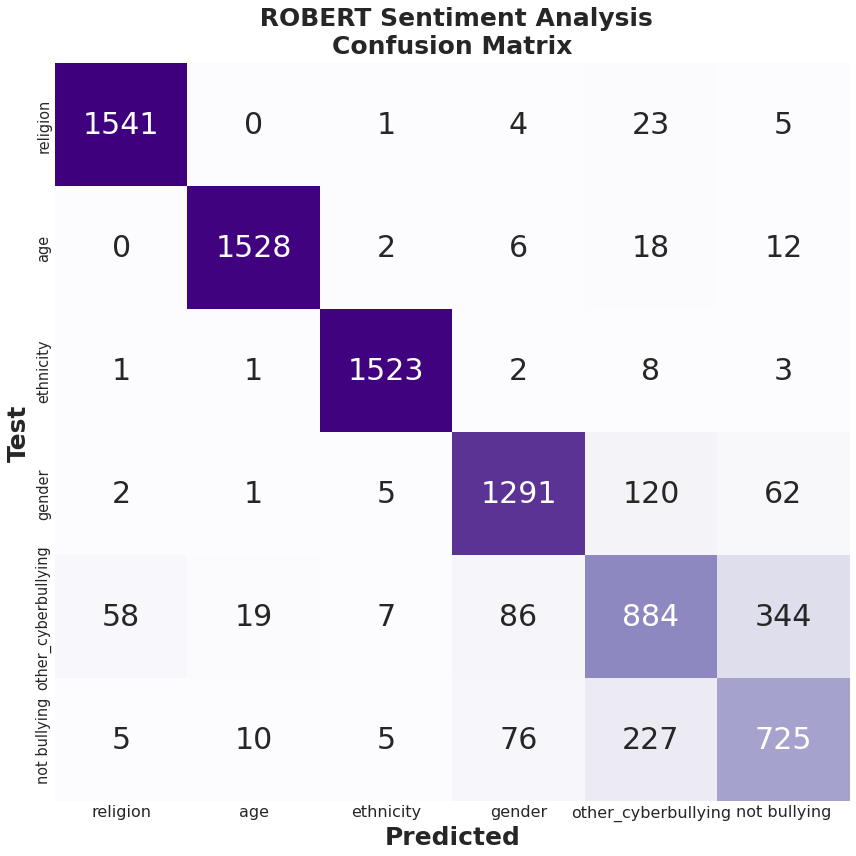

In [58]:
conf_matrix(y_test, roberta_preds,' ROBERT Sentiment Analysis\nConfusion Matrix', sentiments)# 4epochs

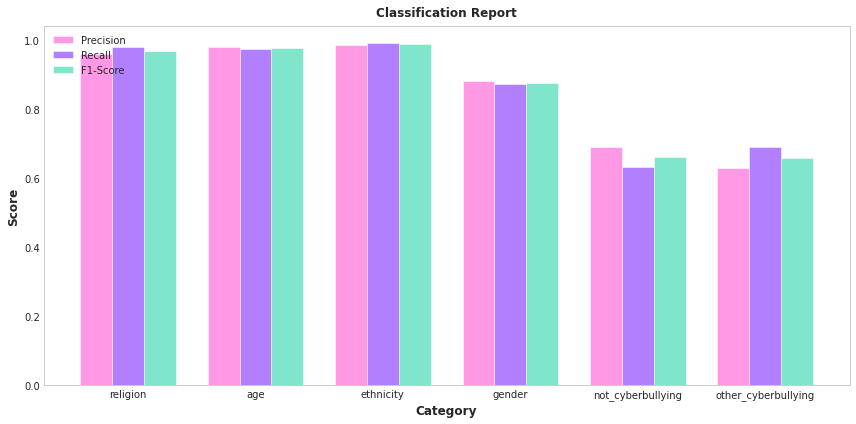

In [59]:
# Generate the classification report
report = classification_report(y_test, roberta_preds, output_dict=True)

# Plotting the classification report
fig, ax = plt.subplots(figsize=(12, 6))

# Categories for the classification
categories = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'

# Extracting precision, recall, and f1-score
precision = [report[category]['precision'] for category in categories]
recall = [report[category]['recall'] for category in categories]
f1_score = [report[category]['f1-score'] for category in categories]

# Setting the positions and width for the bars
pos = list(range(len(categories)))
width = 0.25 

# Plotting each metric
plt.bar(pos, precision, width, alpha=0.5, color='#ff33cc', label='Precision')
plt.bar([p + width for p in pos], recall, width, alpha=0.5, color='#6600ff', label='Recall')
plt.bar([p + width*2 for p in pos], f1_score, width, alpha=0.5, color='#00cc99', label='F1-Score')

# Adding the aesthetics
plt.xlabel('Category')
plt.ylabel('Score')
plt.title('Classification Report')
plt.xticks([p + width for p in pos], ['religion',
    'age',
    'ethnicity',
    'gender',
    'not_cyberbullying',
    'other_cyberbullying'])

# Adding the legend and showing the plot
plt.legend(['Precision', 'Recall', 'F1-Score'], loc='upper left')
plt.grid()
plt.show()

# Conclusion: This script demonstrates how

In [68]:
#roberta_classifier=Roberta_Classifier(freeze_bert=False)
roberta_classifier = torch.load('/kaggle/working/roberta_classifier.pth')

In [69]:
roberta_classifier

Roberta_Classifier(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [70]:
def classify_text(text,model=roberta_classifier, tokenizer = rob_tokenizer,  max_length=128):
    # Tokenize input text
    text = strip_emoji(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = remove_mult_spaces(text)
    text = remove_short_words(text)
    #text = remove_short_tweets(text)
    
    inputs = tokenizer(text)
    
    encoded_sent = tokenizer.encode_plus(
            text=text,
            add_special_tokens=True,         # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length 
            return_attention_mask=True      # Return attention mask
            )
    input_ids = encoded_sent.get('input_ids')
    attention_mask = encoded_sent.get('attention_mask')
    input_ids = torch.tensor(input_ids)[None, :].to(device)
    attention_mask = torch.tensor(attention_mask)[None, :].to(device)
    
    print("text : ", text)
    # Retrieve input tensors
    #input_ids = inputs[0]#['input_ids']
    """print("input_ids",input_ids)
    print("input_ids shape = ",input_ids.shape)"""
    #attention_mask = inputs[1]#['attention_mask']
    """print("attention_mask shape = ",attention_mask.shape)
    print("attention_mask = ",attention_mask)"""
   
    model.to(device)
    model.eval() 
    # Perform inference
    
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        logits = torch.nn.functional.softmax(logits,dim=1)
    #print("Logits : ",logits)
    label = torch.argmax(logits,dim=1).cpu().numpy()
    """print("label: ", label)
    print("output shape: ",logits.shape)
    print('predicted_class_idx : ',label)"""
  
    # Assuming you have a list of class labels
    class_labels = ["religion", "age", "ethnicity", "gender", "not_cyberbullying", "other_cyberbullying"]

    # Get predicted class label
    predicted_class_label = class_labels[label[0]]

    return predicted_class_label, logits.tolist()[0]

In [72]:
# Example usage:
# Assuming 'model' is your pre-trained RoBERTa-based classifier model
# and 'tokenizer' is the corresponding tokenizer
# Set model to evaluation mode
MAX_LEN = 128
text_input = input("Enter the tweet: ")#"I always see this guy on the city bus who I used to be friends with in high school. We stopped being friends bc he gave my phone number to a girl who bullied me. Every time I see him on the bus, he gives me dirty looks??"

predicted_label, probabilities = classify_text(text_input)
print("Predicted Label:", predicted_label)
print("Probabilities:", probabilities)


text :  always see guy city bus used friends high school stopped friends bc gave phone number girl bullied every time see bus gives dirty looks
Predicted Label: age
Probabilities: [0.0002574996615294367, 0.9978972673416138, 0.00017786504758987576, 0.0006209260900504887, 0.0007582564721815288, 0.0002881767286453396]


torch.Size([])

In [1]:
text = input("Enter a text  : ")

Enter a text  :  lasfl ajlkfjaksljflkasjfkl jklaj lkdjakls jlk jakl 


In [2]:
print(text)

lasfl ajlkfjaksljflkasjfkl jklaj lkdjakls jlk jakl 


Thank your for checking out my notebook! Let me know if you have comments or if you want me to check out your work! :)